## Only despike signature AST data

In [1]:
# Imports
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy.io import loadmat
from scipy.signal import detrend
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime as DT
from datetime import timedelta as TD
from cftime import date2num
from astropy.stats import mad_std
from PyPDF2 import PdfFileMerger, PdfFileReader
from roxsi_pyfuns import despike as rpd
from roxsi_pyfuns import transfer_functions as rptf
from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns.preprocess import signature_preprocess as rpsp

import warnings
warnings.filterwarnings('ignore')

ser = '103088'
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Hopkins2023/'
datadir = os.path.join(rootdir, 'Signatures')
outdir = os.path.join(datadir, 'Level1', ser)
fns_mat = sorted(glob.glob(os.path.join(datadir, 'Raw', ser, '*.mat')))
fn_minfo = os.path.join(rootdir, 'Hopkins_SSA_2023_mooring_info.xlsx')


/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Read raw Signature data from .mat files and despike AST signals using GP method.

In [2]:
# Start/end of processing
t0 = pd.Timestamp('2023-09-26 08:00') 
t1 = pd.Timestamp('2023-10-25 12:00')

# Initialize class
adcp = rpsp.ADCP(datadir=rootdir, ser=ser, mooring_info=fn_minfo, 
                 outdir=outdir, patm=None, bathy=None)

# Set number of z-levels in ADCP data
if ser == '103110':
    nz = 24
elif ser == '103094':
    nz = 37
elif ser == '103088':
    nz = 46
else:
    nz = 28
for i,fnm in enumerate(tqdm(fns_mat)):
    # Read only timestamps from mat file 
    _, tsm = adcp.read_mat_times(fn_mat=fnm)
    # Check that file is within processing period
    if tsm[0] > t1:
        # Don't process too far to the end of experiment
        continue
    if tsm[-1] < t0:
        # Don't process too close to the start of experiment
        continue
    # Check if file within processing period
    # Read mat structure for velocities and 1D timeseries
    dfv = adcp.loaddata_vel(fnm, despike_ast=True, n_zlev=nz, only_ast=True)

  0%|          | 0/47 [00:00<?, ?it/s]

ValueError: conflicting sizes for dimension 'z': length 46 on the data but length 28 on coordinate 'z'

In [3]:
# Reference date for timestamps
ref_date=pd.Timestamp('2000-01-01')
# Combine despiked AST .csv files to one netcdf
fns_csv = sorted(glob.glob(os.path.join(outdir, 'AST_despiked', '*.csv')))
dfl = [] # List of pd.DataFrames for concatenating
# Output concatenated nc filename
fn_nc_out = os.path.join(outdir, f'AST_despiked_{ser}.nc')
for fnc in tqdm(fns_csv):
    # Read dataframe, append to list
    df = pd.read_csv(fnc, parse_dates=['time']).set_index('time')
    dfl.append(df[['raw', 'des', 'raw_eta', 'des_eta']])
# Concatenate dataframes, 
dfc = pd.concat(dfl)
# Convert time array to numerical format
time_units = 'seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
time_vals = date2num(dfc.index.to_pydatetime(), time_units, calendar='standard', 
                     has_year_zero=True)
dfc.index = time_vals
dfc.index = dfc.index.rename('time')
# Convert to xr.Dataset
dsc = dfc.to_xarray()
# Sort by time just in case
dsc = dsc.sortby('time')
# Time attributes
dsc.time.encoding['units'] = time_units
dsc.time.attrs['units'] = time_units
dsc.time.attrs['standard_name'] = 'time'
dsc.time.attrs['long_name'] = 'Local time (PDT)'
# Variable attributes
dsc.raw.attrs['standard_name'] = 'depth'
dsc.raw.attrs['long_name'] = 'Raw AST distance to sea surface'
dsc.raw.attrs['units'] = 'm'
dsc.raw_eta.attrs['standard_name'] = 'sea_surface_height_above_mean_sea_level'
dsc.raw_eta.attrs['long_name'] = 'Raw AST sea surface elevation over 20-minute mean level'
dsc.raw_eta.attrs['units'] = 'm'
dsc.des.attrs['standard_name'] = 'depth'
dsc.des.attrs['long_name'] = 'Despiked AST distance to sea surface'
dsc.des.attrs['units'] = 'm'
dsc.des_eta.attrs['standard_name'] = 'sea_surface_height_above_mean_sea_level'
dsc.des_eta.attrs['long_name'] = 'Despiked AST sea surface elevation over 20-minute mean level'
dsc.des_eta.attrs['units'] = 'm'
if 'pressure' in dsc.keys():
    dsc.pressure.attrs['standard_name'] = 'sea_water_pressure_due_to_sea_water'
    dsc.pressure.attrs['long_name'] = 'Water pressure'
    dsc.pressure.attrs['units'] = 'dbar'
# Global attributes
dsc.attrs['title'] = f'Signature1000 despiked AST {ser}'
dsc.attrs['summary'] = ('ROXSI 2023 Hopkins Small-Scale Array despiked ' + 
                        'Signature1000 AST data from serial number {}'.format(ser))
dsc.attrs['instrument'] = 'Nortek Signature 1000'
dsc.attrs['serial_number'] = ser
dsc.attrs['Conventions'] = 'CF-1.8'
dsc.attrs['featureType'] = "timeSeries"
dsc.attrs['source'] =  "Sub-surface observation"
dsc.attrs['date_created'] = str(DT.utcnow()) + ' UTC'
dsc.attrs['references'] = 'https://github.com/mikapm/pyROXSI'
dsc.attrs['creator_name'] = "Mika P. Malila"
dsc.attrs['creator_email'] = "mikapm@met.no"
# Set encoding before saving
fillvalue = -9999.
encoding = {'time': {'zlib': False, '_FillValue': None},
            }     
# Set variable fill values
for k in list(dsc.keys()):
    encoding[k] = {'_FillValue': fillvalue}
# Save to netcdf
dsc.to_netcdf(fn_nc_out, encoding=encoding)


  0%|          | 0/33 [00:00<?, ?it/s]

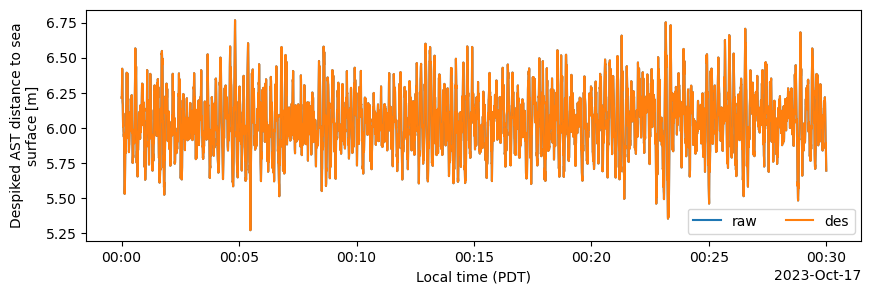

In [4]:
# Read netcdf
fn_nc_out = os.path.join(outdir, f'AST_despiked_{ser}.nc')
dsc = xr.open_dataset(fn_nc_out, decode_coords='all')
# Test plot
fig, ax = plt.subplots(figsize=(10,3))
t0 = pd.Timestamp('2023-10-17 00:00')
t1 = pd.Timestamp('2023-10-17 00:30')
dsc.raw.sel(time=slice(t0,t1)).plot(ax=ax, label='raw')
dsc.des.sel(time=slice(t0,t1)).plot(ax=ax, label='des')
ax.legend(ncols=2)
plt.show()

<xarray.DataArray 'time' (time: 1606485)> Size: 13MB
array(['2023-09-24T08:00:00.126003072', '2023-09-24T08:00:00.376001920',
       '2023-09-24T08:00:00.625990016', ..., '2023-10-08T02:40:53.375792000',
       '2023-10-08T02:40:53.625991936', '2023-10-08T02:40:53.875991040'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 13MB 2023-09-24T08:00:00.126003072 ... 202...
Attributes:
    standard_name:  time
    long_name:      Local time (PDT)

In [42]:
'des' in dsc.keys()

True